# Finetuning of BERT - Multi Label
This notebook is an adaptation of the `AFFECT-FINETUNING-BERTino_for_multi_label_text_classification.ipynb` notebook presented in class. 

The purpose is to finetune BERT (`bert-base-cased`) on our dataset, with the aim of doing multi-label classification over the labels:
- Dairy Free
- Gluten Free
- Low Carb
- Low Fat
- Low Sodium
- Veg

In [16]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

import torch
import numpy as np
import pandas as pd
import random

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Features, Value, DatasetDict
from tqdm import tqdm

seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset Loading
We will use the cleaned dataset obtained in `Data_Understanding.ipynb`.

In [17]:
df = load_dataset('csv', data_files='dataset/dataset.csv')

In [18]:
# See datatype of df
print(type(df))

<class 'datasets.dataset_dict.DatasetDict'>


In [19]:
df.keys()

dict_keys(['train'])

In [20]:
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Vegetarian': Value(dtype='int64', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Dessert': Value(dtype='int64', id=None),
 'Meat': Value(dtype='int64', id=None),
 'Fish': Value(dtype='int64', id=None),
 'Dairy': Value(dtype='int64', id=None),
 'Vegetarian&Dessert': Value(dtype='int64', id=None),
 'Meat&Fish': Value(dtype='int64', id=None)}

In [21]:
# first 2 instances of dataset
df['train'][:2]

{'cooking_method': ["['Set the racks in the middle and upper thirds of the oven and preheat the oven to 425 F', 'In a large skillet over medium heat, heat the olive oil until shimmering. Add the onion, garlic and red pepper flakes and cook until golden, stirring occasionally, about 5 minutes.', 'Add the fennel and cook until the vegetables are soft and translucent, an additional 3 to 5 minutes.', 'Reduce the heat to medium and add the tomatoes with their juices. Using the back of a wooden spoon, smash the tomatoes and cook for 5 minutes.', 'Add the basil, wine, olives, 1 teaspoon salt, and 1/8 teaspoon black pepper.', 'Reduce to low and simmer for 15 minutes, or until the sauce is slightly thickened, while you prepare the fish.', 'Pat the fillets dry, lightly spray them with cooking spray, and season with salt and pepper.', 'In a heavy ovenproof skillet over high heat, heat the olive oil until shimmering. Add the fillets, rounded-side down, and cook for 2 minutes.', 'Carefully flip the

## Data Casting
As we can see a few cells above, the first 3 features are already in the wanted data type: `string`. Let's cast the others into `bool` (... and make other adjustments). 

In [22]:
# REMOVE columns Vegetarian, Desert, Dairy, Meat, Fish, Meat&Fish since we will consider Vegetarian&Dessert
df = df.remove_columns(['Vegetarian', 'Dessert', 'Dairy', 'Meat', 'Fish', 'Meat&Fish'])

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Vegetarian&Dessert': Value(dtype='int64', id=None)}

In [23]:
# RENAME columns Vegetarian&Dessert to Veg

def rename_column(example):
    # Rename 'Vegetarian&Dessert' to 'Veg'
    if 'Vegetarian&Dessert' in example:
        example['Veg'] = example.pop('Vegetarian&Dessert')
    return example

# Apply the rename_column function to each example in the dataset
for split in df.keys():
    df[split] = df[split].map(rename_column)

df['train'].features

Map:   0%|          | 0/79617 [00:00<?, ? examples/s]

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Veg': Value(dtype='int64', id=None)}

In [24]:
# CAST variables to boolean
df['train'] = df['train'].cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

df['train'].features

Casting the dataset:   0%|          | 0/79617 [00:00<?, ? examples/s]

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': Value(dtype='bool', id=None)}

## Split
Let's split our dataset stratifying on `Veg`. We keep the 30% of the datasrt for Test, and the remaining 70% is splittet as 80/20 for the Train and Validation.

In [25]:
# Percentage of Veg recipes
sum(df['train']['Veg'])/len(df['train'])*100

32.85228029189746

In [26]:
# drop the recipes with more than 512 tokens
df['train'] = df['train'].filter(lambda x: len(x['cooking_method'].split()) <= 512)

Filter:   0%|          | 0/79617 [00:00<?, ? examples/s]

In [27]:
len(df['train'])

78296

In [29]:
# column we want to stratify with respect to
stratify_column_name = "Veg"

# create class label column and stratify
df['train'] = df['train'].class_encode_column(stratify_column_name)

Stringifying the column:   0%|          | 0/78296 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/78296 [00:00<?, ? examples/s]

In [30]:
# Notice that now Veg has 'False' and 'True' as class labels
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': ClassLabel(names=['False', 'True'], id=None)}

In [32]:
# split the dataset into train, validation and test stratifying with respect to Veg
df = df['train'].train_test_split(test_size=0.3, seed = seed, stratify_by_column = 'Veg')
train_validation = df['train'].train_test_split(test_size=0.2, seed = seed, stratify_by_column='Veg')

dataset = DatasetDict()
dataset['test'] = df['test']
dataset['train'] = train_validation['train']
dataset['validation'] = train_validation['test']
dataset.shape

{'test': (23489, 9), 'train': (43845, 9), 'validation': (10962, 9)}

In [33]:
# CAST 'Veg' back to boolean for split in dataset.keys()
dataset = dataset.cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

Casting the dataset:   0%|          | 0/23489 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/43845 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10962 [00:00<?, ? examples/s]

In [35]:
# print the distribution of each label: Veg, Dairy Free, Gluten Free, Low Carb, Low Fat, Low Sodium in the train, test and val set

def class_distribution(dataset, column):
    num_1 = sum(dataset[column])
    num_0 = len(dataset) - num_1
    perc_1 = num_1/len(dataset)*100
    perc_0 = num_0/len(dataset)*100
    if column == 'Veg':
        return f"Vegetarian 1: \t {round(perc_1, 1)}% \t Vegetarian 0:\t {round(perc_0, 1)}%"
    return f"{column} 1: \t {round(perc_1, 1)}% \t {column} 0:\t {round(perc_0, 1)}%"


for split in dataset.keys():
    print(split)
    for column in dataset[split].features:
        if dataset[split].features[column].dtype == 'bool' or dataset[split].features[column].dtype == 'ClassLabel':
            print(class_distribution(dataset[split], column))
    print("\n")

test
Dairy Free 1: 	 0.5% 	 Dairy Free 0:	 99.5%
Gluten Free 1: 	 43.7% 	 Gluten Free 0:	 56.3%
Low Carb 1: 	 4.7% 	 Low Carb 0:	 95.3%
Low Fat 1: 	 10.9% 	 Low Fat 0:	 89.1%
Low Sodium 1: 	 19.0% 	 Low Sodium 0:	 81.0%
Vegetarian 1: 	 32.5% 	 Vegetarian 0:	 67.5%


train
Dairy Free 1: 	 0.6% 	 Dairy Free 0:	 99.4%
Gluten Free 1: 	 43.3% 	 Gluten Free 0:	 56.7%
Low Carb 1: 	 5.0% 	 Low Carb 0:	 95.0%
Low Fat 1: 	 11.4% 	 Low Fat 0:	 88.6%
Low Sodium 1: 	 18.8% 	 Low Sodium 0:	 81.2%
Vegetarian 1: 	 32.5% 	 Vegetarian 0:	 67.5%


validation
Dairy Free 1: 	 0.5% 	 Dairy Free 0:	 99.5%
Gluten Free 1: 	 43.7% 	 Gluten Free 0:	 56.3%
Low Carb 1: 	 4.9% 	 Low Carb 0:	 95.1%
Low Fat 1: 	 11.3% 	 Low Fat 0:	 88.7%
Low Sodium 1: 	 18.9% 	 Low Sodium 0:	 81.1%
Vegetarian 1: 	 32.5% 	 Vegetarian 0:	 67.5%




Notice that `Veg` is obviously straified, but also the other features are well distributed between Train/Val/Test.

Now, let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [36]:
dataset['train'].features.keys()

dict_keys(['cooking_method', 'ingredients', 'tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Veg'])

In [39]:
labels = [label for label in dataset['train'].features.keys() if label not in ['cooking_method','ingredients','tags']]
labels

['Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Veg']

In [40]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

id2label, label2id

({0: 'Dairy Free',
  1: 'Gluten Free',
  2: 'Low Carb',
  3: 'Low Fat',
  4: 'Low Sodium',
  5: 'Veg'},
 {'Dairy Free': 0,
  'Gluten Free': 1,
  'Low Carb': 2,
  'Low Fat': 3,
  'Low Sodium': 4,
  'Veg': 5})

## Data Preprocessing

In [41]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [42]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["cooking_method"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [43]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/23489 [00:00<?, ? examples/s]

Map:   0%|          | 0/43845 [00:00<?, ? examples/s]

Map:   0%|          | 0/10962 [00:00<?, ? examples/s]

In [44]:
encoded_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

Let's experiment with a recipe to understand the functioning of each step.

In [45]:
i = encoded_dataset['train'][0]['input_ids']
len(i)

512

In [52]:
# let's see how many pads are added
pads = [token for token in i if token == 0]
len(pads)

228

In [46]:
# notice that the last tokens are [PAD] tokens!
tokenizer.decode(i)

'[CLS] [\'Directions \',\'Preheat oven to 425. \',\'Mix sugar, cinnamon, chopped nuts, and chocolate chips in mixing bowl. \',\'Melt butter in medium saucepan / \',\'Place one sheet of filo dough in an 11x9 pan and butter it, continuing until you have used 1 / 8 to 1 / 4 of the package ( my personal preference ). \',\'Then spread on a layer of chocolate mixture. Repeat with filo dough and chocolate until all is used. \',\'Cut into 1 " squares. Place in oven and bake about 35 minutes ( until golden brown ). \',\'While that is baking, in a medium saucepan over medium - low, heat the honey, water, and lemon juice until it comes to a light boil. Remove from heat. \',\'Once your baklava is out of the oven, place the pan on a cookie sheet and immediately pour syrup mixture over. BE CAREFUL THE SYRUP WILL MOST LIKELY START TO BOIL IMMEDIATELY ( sometimes overflowing onto the cookie sheet ). Allow to cool, then enjoy. \',\'For looks I sometimes melt a few chocolate chips and drizzle them on to

In [53]:
encoded_dataset['train'][0]['labels']

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]

In [48]:
# We can see the labels of the recipe in this way
[id2label[idx] for idx, label in enumerate(encoded_dataset['train'][0]['labels']) if label == 1.0]

['Low Sodium', 'Veg']

Now, let's make Train/Val/Test PyTorch datasets.

In [54]:
encoded_dataset.set_format("torch")

In [55]:
type(encoded_dataset)

datasets.dataset_dict.DatasetDict

In [56]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", 
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train the model!
We tried different configurations of the hyperparameters; the best one is reported below.

In [ ]:
args = TrainingArguments(
    f"google-bert/bert-base-cased",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    save_steps = 250,
    eval_steps = 250,
    save_total_limit = 2,
    learning_rate = 1e-4,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,
    weight_decay = 0.05,
    warmup_steps = 2,
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    #push_to_hub = True
)

In [63]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset = encoded_dataset["train"],
    eval_dataset = encoded_dataset["validation"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

# Evaluation

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model("./models/bert-finetuned-group15")

---

# Testing the finetuned model

In [36]:
# NOTE: run this cell if you don't have the finetuned model in memory and change the path to the location of the model
path = './models/bert-finetuned2-group15'
model = AutoModelForSequenceClassification.from_pretrained(path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [37]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score

def multi_label_metrics_test(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    precision_micro = precision_score(y_true, y_pred, average='micro')

    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')

    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')


    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'recall': recall_micro,
               'precision': precision_micro,
               'f1_macro': f1_macro_average,
               'recall_macro': recall_macro,
               'precision_macro': precision_macro,
               'f1_weighted': f1_weighted_average,
               'recall_weighted': recall_weighted,
               'precision_weighted': precision_weighted
               }
    
    return metrics, y_true, y_pred

def compute_metrics_test(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result, y_true, y_pred = multi_label_metrics_test(
        predictions=preds, 
        labels=p.label_ids)
    
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    fig, axs = plt.subplots(2, 3, figsize=(16, 9))

    for i, cm in enumerate(mcm):
        row = i // 3
        col = i % 3
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[row, col])
        axs[row, col].set_xlabel('Predicted labels')
        axs[row, col].set_ylabel('True labels')
        axs[row, col].set_title(f'Label: {id2label[i]}')

    plt.subplots_adjust(hspace = 0.3)
    plt.show()

    return result

In [38]:
dataset['test']
print("Keys in dataset:", dataset.keys())

# Check the length of the test dataset
print("Length of test dataset:", len(dataset['test']))

print(len(dataset['test']))

Keys in dataset: dict_keys(['test', 'train', 'validation'])
Length of test dataset: 23813
23813


In [39]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_test
)

# Evaluate on the test set
results = trainer.evaluate(eval_dataset=encoded_dataset['test'])

print(results)

  0%|          | 0/2977 [00:00<?, ?it/s]

In [82]:
results

{'eval_loss': 0.19610799849033356,
 'eval_f1': 0.8205946613470124,
 'eval_roc_auc': 0.8853940396868855,
 'eval_accuracy': 0.6985260152017806,
 'eval_recall': 0.8078707167439773,
 'eval_precision': 0.8337258232637146,
 'eval_f1_macro': 0.6538451707883538,
 'eval_recall_macro': 0.6225582438740682,
 'eval_precision_macro': 0.6974345678786203,
 'eval_f1_weighted': 0.8159077580429788,
 'eval_recall_weighted': 0.8078707167439773,
 'eval_precision_weighted': 0.8266009999306082,
 'eval_runtime': 1796.5682,
 'eval_samples_per_second': 13.255,
 'eval_steps_per_second': 1.657}

In [89]:
metrics = results
metrics = {k: v for k, v in metrics.items() if k in ['eval_f1', 'eval_roc_auc', 'eval_accuracy', 'eval_recall', 'eval_precision']}
metrics

{'eval_f1': 0.8205946613470124,
 'eval_roc_auc': 0.8853940396868855,
 'eval_accuracy': 0.6985260152017806,
 'eval_recall': 0.8078707167439773,
 'eval_precision': 0.8337258232637146}

C:\Users\chucki\AppData\Local\Temp\ipykernel_10988\3684922624.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


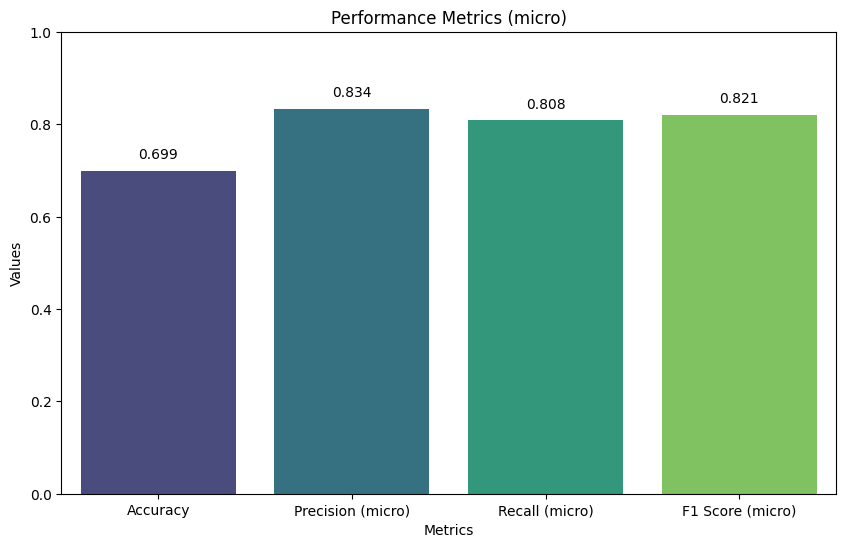

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
accuracy = metrics['eval_accuracy']
precision = metrics['eval_precision']
recall = metrics['eval_recall']
f1_score = metrics['eval_f1']

# Plotting Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision (micro)', 'Recall (micro)', 'F1 Score (micro)']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Performance Metrics (micro)')
plt.ylim(0, 1)
for i in range(len(values)):
    plt.text(i, values[i] + 0.02, f'{values[i]:.3f}', ha='center', va='bottom')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()


C:\Users\chucki\AppData\Local\Temp\ipykernel_10988\924100362.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


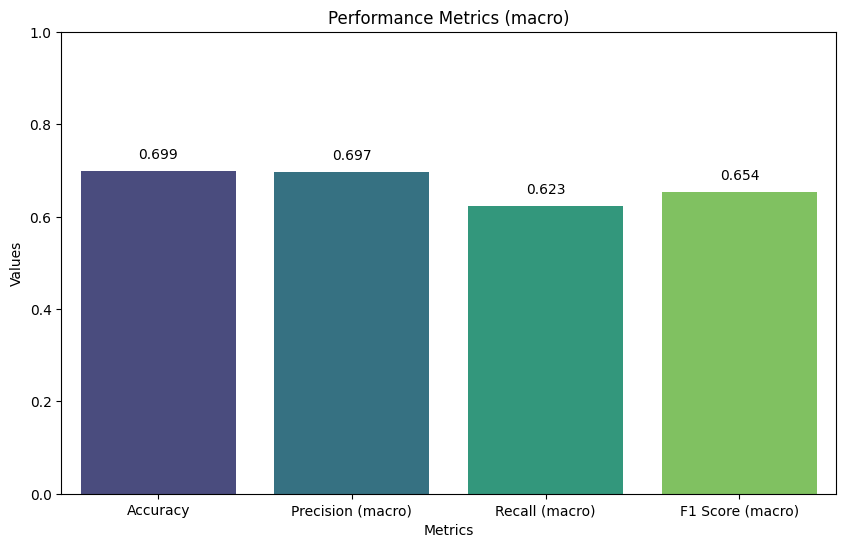

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
accuracy = metrics['eval_accuracy']
precision = metrics['eval_precision_macro']
recall = metrics['eval_recall_macro']
f1_score = metrics['eval_f1_macro']

# Plotting Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 Score (macro)']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Performance Metrics (macro)')
plt.ylim(0, 1)
for i in range(len(values)):
    plt.text(i, values[i] + 0.02, f'{values[i]:.3f}', ha='center', va='bottom')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()
